# Imports

In [1]:
import pandas as pd

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import graphviz

# Read data

In [2]:
df = pd.read_csv("../data/toy_data.csv", index_col=0)

In [3]:
df.head()

,x,y,type
0,-0.804458,0.320932,yes
1,-0.025483,0.644324,yes
2,-0.300797,0.389475,yes
3,-0.107437,-0.479983,yes
4,0.595036,-0.464668,yes


# Generate Training and Testing Data

In [4]:
feat_names = df.columns[:-1]
class_names = df['type'].unique()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df['type'],
                                                    test_size=0.25,
                                                    random_state=42)

# Training and Fitting the Model

In [6]:
decision_tree_classifier = tree.DecisionTreeClassifier(max_depth=2, random_state=0)
decision_tree_classifier = decision_tree_classifier.fit(X_train, y_train)

# Visualizing the Decision Tree

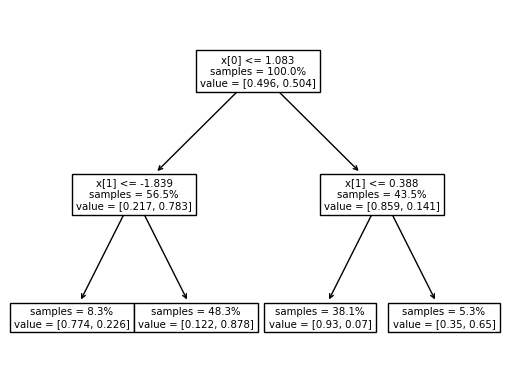

In [25]:
fig, ax = plt.subplots(1,1)
tree.plot_tree(decision_tree_classifier, ax=ax, impurity=False, proportion=True);

# Visualizing Decision Tree using Graphviz

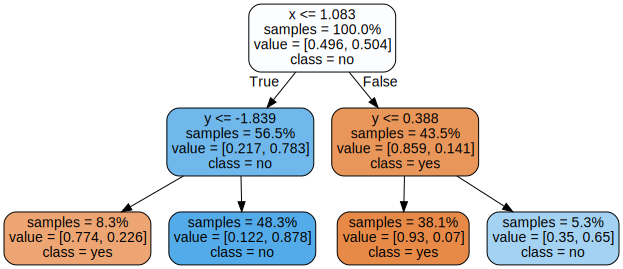

In [26]:
dot_data = tree.export_graphviz(decision_tree_classifier, out_file=None,
                                feature_names=feat_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                impurity=False, proportion=True)
graph = graphviz.Source(dot_data)
graph.render("../images/test")

graph

# Making predictions

In [9]:
predictions = decision_tree_classifier.predict(X_test)
probabilities = decision_tree_classifier.predict_proba(X_test)
results_df = pd.DataFrame({'prob of no':probabilities[:,0],
                         'prob of yes':probabilities[:,1],
                         'predicted class':predictions,
                         'actual class': y_test})
results_df.head()

,prob of no,prob of yes,predicted class,actual class
361,0.930070,0.069930,no,no
73,0.121547,0.878453,yes,yes
374,0.930070,0.069930,no,no
155,0.121547,0.878453,yes,yes
104,0.930070,0.069930,no,yes


# Checking Accuracy

In [10]:
accuracy = decision_tree_classifier.score(X_test, y_test)
accuracy

0.912

# Visualizing Decision Boundaries

In [11]:
colors = []
for y in y_test:
    if y == 'yes':
        colors.append('green')
    else:
        colors.append('red')
for_scatter = X_test.copy(deep=True)
        
for_scatter['type'] = y_test
for_scatter['color'] = colors

yesses = for_scatter[for_scatter['type']=='yes']
nos = for_scatter[for_scatter['type']=='no']

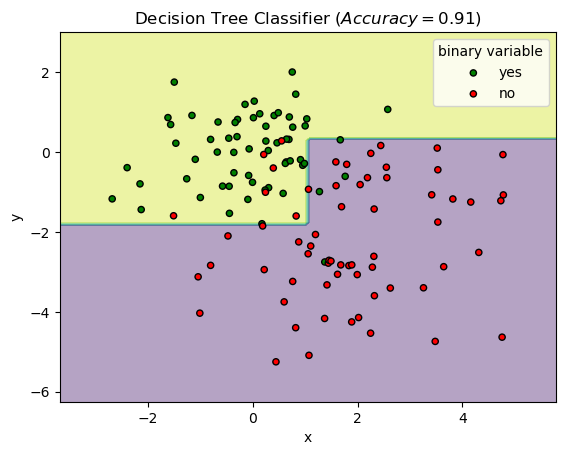

In [12]:
fig, ax = plt.subplots(1,1)
DecisionBoundaryDisplay.from_estimator(decision_tree_classifier, X_test, alpha=0.4, response_method="predict", ax=ax)
ax.scatter(yesses['x'], yesses['y'], c=yesses['color'], s=20, edgecolor="k", label='yes')
ax.scatter(nos['x'], nos['y'], c=nos['color'], s=20, edgecolor="k", label='no')
ax.legend(title='binary variable')
ax.set_title(f'Decision Tree Classifier $(Accuracy = {accuracy:.2f})$')
plt.show()

# Confusion Matrix

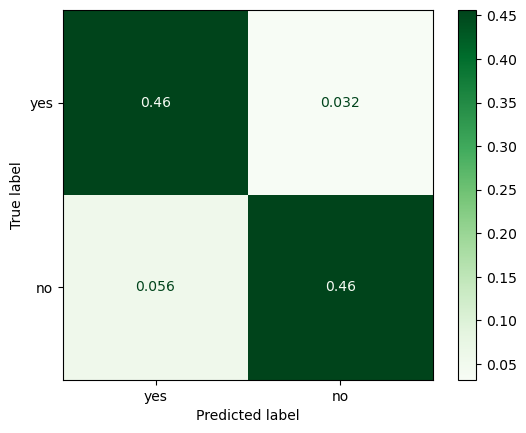

In [13]:
cm = confusion_matrix(y_test, predictions,
                      labels=class_names,
                      normalize='all')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot(cmap='Greens')
plt.show()